# PCA Example
## Derive a PCA model from dataset and apply to new data

In this example, we demonstrate:

- read in some NCEP-CFSR data, 
- train a PCA model with incremental-PCA, and
- apply the trained PCA model on a MRI dataset (re-gridded into same resolution)


In [1]:
# Loading library
%matplotlib inline
import os, re, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Input file settings
SRCPATH = '../data/cfsr_mslp/'
TGTPATH = '../data/mri_mslp/'
SRCEXT = '.txt'

# Some helping functions

# Function: collect all data
def get_files(SRCPATH, SRCEXT):
    tmp = []
    for root, dirs, files in os.walk(SRCPATH): 
        for fn in files: 
            if fn.endswith(SRCEXT): 
                #print(fn.replace(SRCEXT,''))
                tmp.append({'time':fn.replace(SRCEXT,''), 'uri':os.path.join(root, fn)})
    #
    tmp = pd.DataFrame(tmp).sort_values(by=['time']).reset_index(drop=True)
    #print(tmp.head())
    # Done
    return(tmp)

# Read data from GRIB-TEXT format
def read_grib_text(furi):
    # Open file and read
    with open(furi, 'r') as f:
        # First line is data dimension
        nx, ny = f.readline().rstrip('\n').split(' ')
        #print((nx, ny))
        # Read the following lines
        data = []
        for i in range(int(nx)*int(ny)):
            #print(f.readline())
            data.append(float(f.readline().rstrip('\n')))
    # Reshape data array
    data = np.array(data).reshape(int(ny),int(nx))
    return(data)

# Show data
#os.environ['PROJ_LIB'] = '/Users/tsyo/anaconda/share/proj/'
#os.environ['PROJ_LIB'] = 'C:\\usr\\Anaconda3\\Library\\share\\'
from mpl_toolkits.basemap import Basemap
# NCEP-CFSR
#   Resolution: 0.5⁰ X 0.5⁰
#   Domain: 0 60 N, 60 180 E
#   Data dimension: (121, 241)
def show_cfsr_grib(furi, title=None):
    # Read data
    tmp = read_grib_text(furi)
    # Create Basemap for CFSR
    lons = np.linspace(60., 180., num=tmp.shape[1])
    lats = np.linspace(0., 60., num=tmp.shape[0])
    x, y = np.meshgrid(lons,lats)
    m = Basemap(llcrnrlon=60., urcrnrlon=180., llcrnrlat=0., urcrnrlat=60.)
    # draw coastlines, state and country boundaries, edge of map.
    m.drawcoastlines()
    m.contourf(x, y, tmp, 30, cmap=plt.cm.jet)
    m.colorbar()
    if title is not None:
        plt.title(title)
    plt.tight_layout()
    plt.show()
    return(0)

# Show data in np.ndarray with shape (121, 241)
def show_cfsr_array(data, title=None):
    # Read data
    tmp = data
    # Create Basemap for CFSR
    lons = np.linspace(60., 180., num=tmp.shape[1])
    lats = np.linspace(0., 60., num=tmp.shape[0])
    x, y = np.meshgrid(lons,lats)
    m = Basemap(llcrnrlon=60., urcrnrlon=180., llcrnrlat=0., urcrnrlat=60.)
    # draw coastlines, state and country boundaries, edge of map.
    m.drawcoastlines()
    m.contourf(x, y, tmp, 30, cmap=plt.cm.jet)
    m.colorbar()
    if title is not None:
        plt.title(title)
    plt.tight_layout()
    plt.show()
    return(0)

In [2]:
# CFSR files
cfsr_files = get_files(SRCPATH, SRCEXT)
print(cfsr_files)
# MRI files
mri_files = get_files(TGTPATH, SRCEXT)
print(mri_files)

            time                                 uri
0   201612010000  ../data/cfsr_mslp/201612010000.txt
1   201612020000  ../data/cfsr_mslp/201612020000.txt
2   201612030000  ../data/cfsr_mslp/201612030000.txt
3   201612040000  ../data/cfsr_mslp/201612040000.txt
4   201612050000  ../data/cfsr_mslp/201612050000.txt
5   201612060000  ../data/cfsr_mslp/201612060000.txt
6   201612070000  ../data/cfsr_mslp/201612070000.txt
7   201612080000  ../data/cfsr_mslp/201612080000.txt
8   201612090000  ../data/cfsr_mslp/201612090000.txt
9   201612100000  ../data/cfsr_mslp/201612100000.txt
10  201612110000  ../data/cfsr_mslp/201612110000.txt
11  201612120000  ../data/cfsr_mslp/201612120000.txt
12  201612130000  ../data/cfsr_mslp/201612130000.txt
13  201612140000  ../data/cfsr_mslp/201612140000.txt
14  201612150000  ../data/cfsr_mslp/201612150000.txt
15  201612160000  ../data/cfsr_mslp/201612160000.txt
16  201612170000  ../data/cfsr_mslp/201612170000.txt
17  201612180000  ../data/cfsr_mslp/2016121800

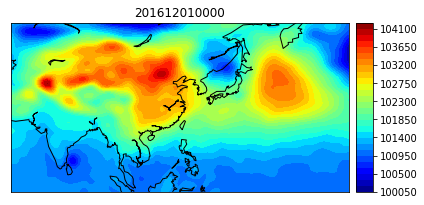

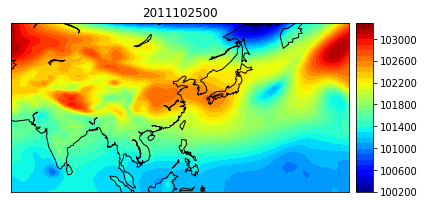

0

In [3]:
# Show some data
show_cfsr_grib(cfsr_files.loc[0, 'uri'], str(cfsr_files.loc[0, 'time']))
show_cfsr_grib(mri_files.loc[0, 'uri'], str(mri_files.loc[0, 'time']))

In [4]:
# Load all data
cfsr = []
for i in range(cfsr_files.shape[0]):
    cfsr.append(read_grib_text(cfsr_files.loc[i, 'uri']).flatten())

cfsr = np.array(cfsr)
print(cfsr.shape)

(31, 29161)


In [5]:
# PCA
from sklearn.decomposition import PCA
# Define parameters
X = cfsr
n_components = 3
# Initialize PCA object
pca = PCA(n_components=n_components)
# Fit PCA model with data
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

Explained Variance Ratio: 
[0.2326924  0.18361552 0.12010744]
Accumulative Explained Variance Ratio: 
[0.2326924  0.41630791 0.53641535]


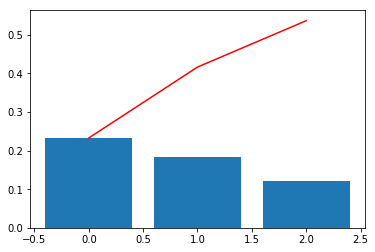

In [6]:
# Check results
print("Explained Variance Ratio: ")
print(pca.explained_variance_ratio_)
print("Accumulative Explained Variance Ratio: ")
print(np.cumsum(pca.explained_variance_ratio_))
# Visualize
plt.bar(range(3),pca.explained_variance_ratio_)
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'r-')
plt.show()

## Incremental PCA

In this example we have only 31 files, so a regular PCA is sufficient. However, in the case we try to derive PCA on a very large dataset, say, larger than your system memory, the [**Incremental PCA**](https://scikit-learn.org/stable/auto_examples/decomposition/plot_incremental_pca.html) comes to our aid.

Incremental principal component analysis (IPCA) is typically used as a replacement for principal component analysis (PCA) *when the dataset to be decomposed is too large to fit in memory*. IPCA builds a low-rank approximation for the input data using an amount of memory which is independent of the number of input data samples. It is still dependent on the input data features, but changing the batch size allows for control of memory usage.

This example serves as a visual check that IPCA is able to find a *similar* projection of the data to PCA (to a sign flip), while only processing a few samples at a time. This can be considered a “toy example”, as IPCA is intended for large datasets which do not fit in main memory, requiring incremental approaches.

In [7]:
from sklearn.decomposition import PCA, IncrementalPCA
# Define parameters
X = cfsr
n_components = 3

# Initialize IPCA object
ipca = IncrementalPCA(n_components=n_components, batch_size=5)
X_ipca = ipca.fit_transform(X)

# Initialize PCA object
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

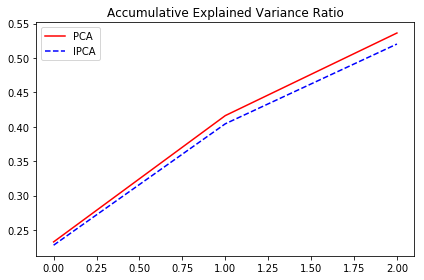

In [8]:
# Visualize the explained variance ratio
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'r-', label='PCA')
plt.plot(np.cumsum(ipca.explained_variance_ratio_), 'b--', label='IPCA')
plt.title('Accumulative Explained Variance Ratio')
plt.legend()
plt.tight_layout()
plt.show()

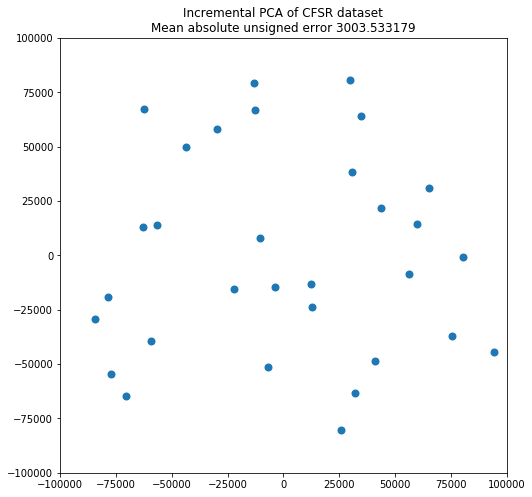

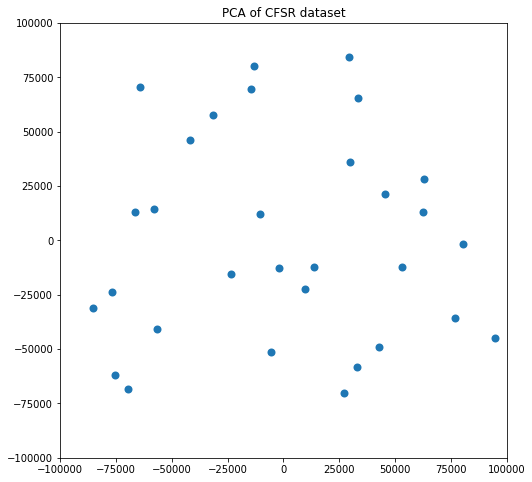

In [9]:
# Visualize points on the PC1-PC2 plane
for X_transformed, title in [(X_ipca, "Incremental PCA"), (X_pca, "PCA")]:
    plt.figure(figsize=(8, 8))
    plt.scatter(X_transformed[:, 0], X_transformed[:, 1], lw=2)

    if "Incremental" in title:
        err = np.abs(np.abs(X_pca) - np.abs(X_ipca)).mean()    # MAE between two projections
        plt.title(title + " of CFSR dataset\nMean absolute unsigned error "  "%.6f" % err)
    else:
        plt.title(title + " of CFSR dataset")
    #plt.legend(loc="best", shadow=False, scatterpoints=1)
    plt.axis([-100000, 100000, -100000, 100000])
plt.show()

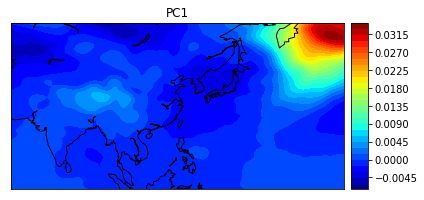

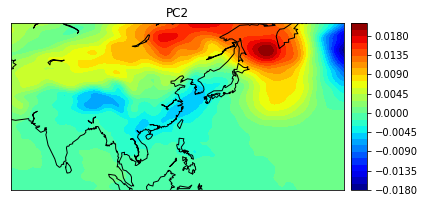

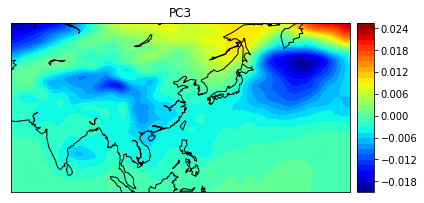

0

In [10]:
# Show PCs
show_cfsr_array(ipca.components_[0].reshape(121,241), 'PC1')
show_cfsr_array(ipca.components_[1].reshape(121,241), 'PC2')
show_cfsr_array(ipca.components_[2].reshape(121,241), 'PC3')

As shown above, IPCA approaximate the complete PCA with some errors but it can handle very large datasets.


## Save the trained PCA model for later use

For a large dataset, the training process is usually a more costly (in terms of computation) step in the analysis. Hence, it is a common practice to save the trained the PCA model for later use. In python, [`pickle`](https://docs.python.org/3/library/pickle.html) is the built-in tool for accessing objects with system files. The following example demonstrate how to do this.

In [11]:
# pickle example
import pickle

# Output to file 'ipca.pkl'
with open('ipca.pkl', 'wb') as f:
    pickle.dump(ipca, f)
    
# Read in object in 'ipca.pkl'
with open('ipca.pkl', 'rb') as f:
    ipca2 = pickle.load(f)

# Check
print(ipca.explained_variance_ratio_)
print(ipca2.explained_variance_ratio_)

[0.22790558 0.17648951 0.11599195]
[0.22790558 0.17648951 0.11599195]


C:\usr\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [12]:
# Read in MRI data
mri = []
for i in range(mri_files.shape[0]):
    mri.append(read_grib_text(mri_files.loc[i, 'uri']).flatten())

mri = np.array(mri)
print(mri.shape)

(2, 29161)


In [15]:
# Project MRI data to PCA space derived from NCEP-CFSR
mri_pca = pca.transform(mri)
mri_ipca = ipca.transform(mri)
    
print(mri_pca)
print(mri_ipca)

[[ 85614.18193527 -21114.29687433 -16364.70656364]
 [  4461.99774428  29792.83523049 -44371.54504176]]
[[ 86561.32746202 -22585.20978165 -29347.92018304]
 [  5890.96490457  29979.4050938  -54954.66738369]]


## Wrapping up

In this example, we demenstrate how to calculate PCA from one dataset and then apply to another dataset. We also introduce how to I/O python objects from/to system files, and the usage of incremental PCA. If your dataset is small enough, say, less than 1/5 of your system memeory, using the complete PCA is safe. Otherwise, IPCA is recommended.